# Churn in Telecom

## Imports

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, classification_report

from sklearn.dummy import DummyClassifier, DummyRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import warnings
warnings.filterwarnings('ignore')

# Data

## Importing Data

In [22]:
churn_data = pd.read_csv('./data/bigml_59c28831336c6604c800002a.csv')

In [23]:
churn_data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [24]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [25]:
churn_data['churn'].value_counts(normalize = True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

The data is imbalanced marginally but could potentially use some balancing when we do our predictions

## Train Test Split

In [26]:
X = churn_data.drop(['phone number','churn'], axis = 1)
y = churn_data.churn

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

In [27]:
X_train.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object')

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 427 to 2732
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2499 non-null   object 
 1   account length          2499 non-null   int64  
 2   area code               2499 non-null   int64  
 3   international plan      2499 non-null   object 
 4   voice mail plan         2499 non-null   object 
 5   number vmail messages   2499 non-null   int64  
 6   total day minutes       2499 non-null   float64
 7   total day calls         2499 non-null   int64  
 8   total day charge        2499 non-null   float64
 9   total eve minutes       2499 non-null   float64
 10  total eve calls         2499 non-null   int64  
 11  total eve charge        2499 non-null   float64
 12  total night minutes     2499 non-null   float64
 13  total night calls       2499 non-null   int64  
 14  total night charge      2499 non-null 

In [29]:
#Creating lists to use in pipelines

cat_cols = ['state', 'international plan', 'voice mail plan','area code']


numeric_cols = ['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls']

In [30]:
# Creating Pipelines with simpleimputer to prepare for data which may have null values in future

subpipe_numeric = Pipeline(steps =[
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps = [
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse = False, handle_unknown='ignore'))
])

In [31]:
# Basic Colum Transformer

CT = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_numeric,numeric_cols),
    ('subpipe_cat', subpipe_cat, cat_cols)
])

# Models

## Baseline Model

In [32]:
dummy_model_pipe = Pipeline([
    ('ct',CT),
    ('dummy', DummyClassifier(strategy = 'most_frequent'))
])

In [33]:
dummy_model_pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
              

In [34]:
dummy_model_pipe.score(X_train, y_train)

0.8527410964385754

In [35]:
dummy_model_pipe.score(X_test, y_test)

0.8621103117505995

In [41]:
print(classification_report(y_test, dummy_model_pipe.predict(X_test)))

              precision    recall  f1-score   support

       False       0.86      1.00      0.93       719
        True       0.00      0.00      0.00       115

    accuracy                           0.86       834
   macro avg       0.43      0.50      0.46       834
weighted avg       0.74      0.86      0.80       834



C:\Users\rchag\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline model predicting majority class has an accuracy of 86%, I would like to maximize recall without sacrificing accuracy in an attempt to retain as many customers as possible without having to offer coupons or discounts unnecessarily 

<AxesSubplot:>

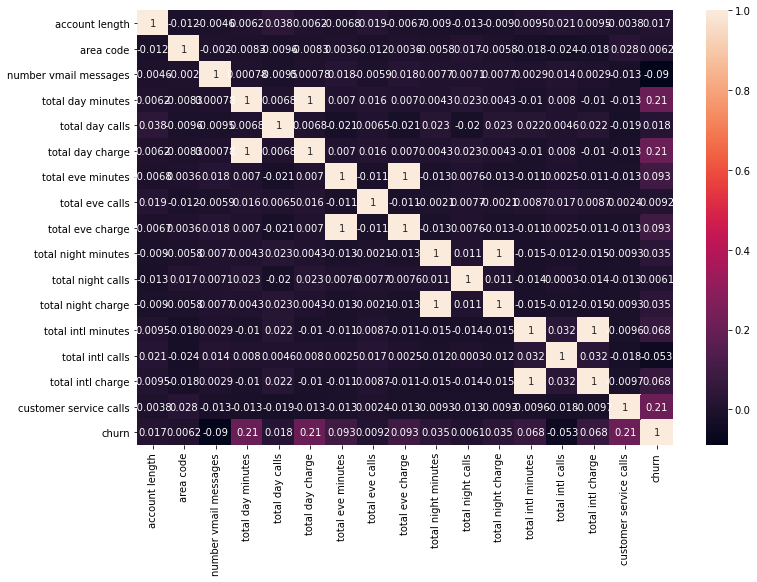

In [42]:
# Looking to see if there are columns that may improve accuracy or recall based on correlation

fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(churn_data.drop(['state', 'international plan', 'voice mail plan'], axis = 1).corr(), annot = True)

## Basic Logistic Regression Model

In [44]:
logreg = Pipeline(steps = [
    ('ct', CT),
    ('logreg', LogisticRegression())
])

In [45]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
              

In [46]:
logreg.score(X_train, y_train)

0.8711484593837535

In [49]:
logreg.score(X_test, y_test)

0.8513189448441247

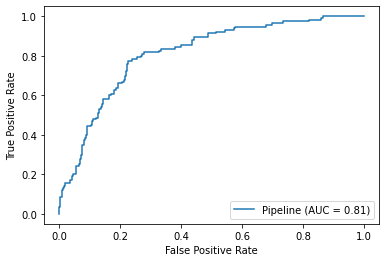

In [51]:
plot_roc_curve(logreg, X_test, y_test)

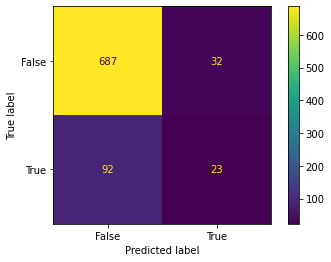

In [53]:
plot_confusion_matrix(logreg, X_test, y_test)

In [54]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

       False       0.88      0.96      0.92       719
        True       0.42      0.20      0.27       115

    accuracy                           0.85       834
   macro avg       0.65      0.58      0.59       834
weighted avg       0.82      0.85      0.83       834



Not a great recall score, I think we should err on the side of caution and try to identify as many cases as churn as possible without drastically decreasing our accuracy score to prevent as many people as possible from leaving the service by perhaps offering incentives on the positively correlated items that seem to have people leave the service

## No states Model

In [56]:
cat_cols_no_states = cat_cols[1:]

In [57]:
CT_no_states = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_numeric,numeric_cols),
    ('subpipe_cat', subpipe_cat, cat_cols_no_states)
])

In [58]:
logreg_no_states = Pipeline([
    ('ct', CT_no_states),
    ('logreg', LogisticRegression())
])

In [59]:
logreg_no_states.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total eve charge',
              

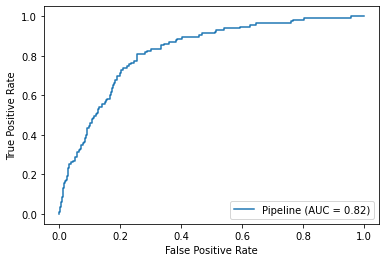

In [60]:
plot_roc_curve(logreg_no_states, X_test, y_test)

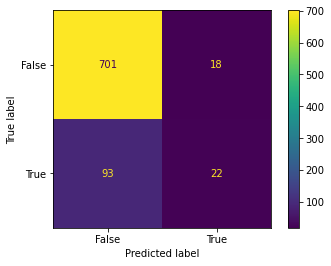

In [61]:
plot_confusion_matrix(logreg_no_states, X_test, y_test)

In [62]:
print(classification_report(y_test, logreg_no_states.predict(X_test)))

              precision    recall  f1-score   support

       False       0.88      0.97      0.93       719
        True       0.55      0.19      0.28       115

    accuracy                           0.87       834
   macro avg       0.72      0.58      0.61       834
weighted avg       0.84      0.87      0.84       834



Looks like our recall decreased and our accuracy only marginally decreased. I think I will keep the states in the model as it seems to help a little bit.

## Correlated columns Model

<AxesSubplot:>

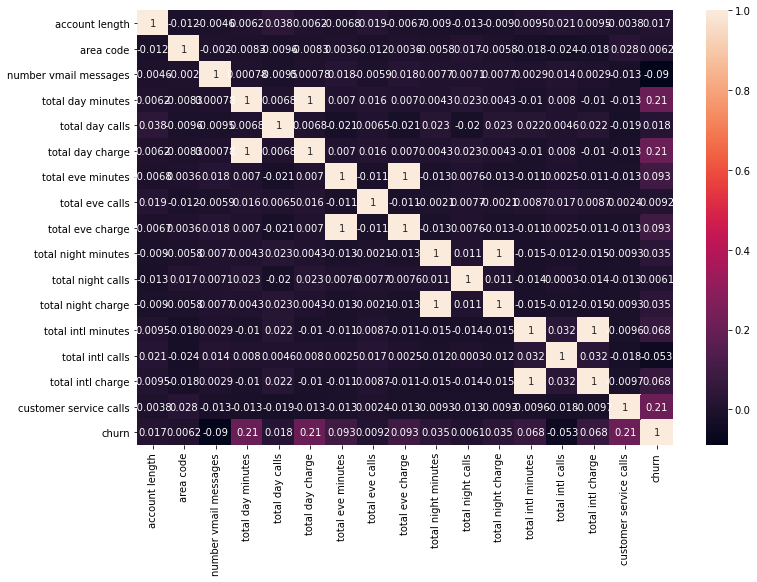

In [55]:
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(churn_data.drop(['state', 'international plan', 'voice mail plan'], axis = 1).corr(), annot = True)

In [63]:
strong_numeric_cols = ['total day minutes', 'total day charge', 'total eve minutes','total eve charge',
                       'customer service calls','number vmail messages', 'total intl calls']

In [64]:
CT_strong = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_numeric,strong_numeric_cols),
    ('subpipe_cat', subpipe_cat, cat_cols)
])

In [65]:
logreg_corr = Pipeline([
    ('ct',CT_strong),
    ('logreg', LogisticRegression())
])

In [66]:
logreg_corr.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['total day minutes',
                                                   'total day charge',
                                                   'total eve minutes',
                                                   'total eve charge',
                                                   'customer service calls',
                                                   'number vmail messages',
                                                   'total intl calls']),
                                                 ('subpipe_cat',
        

In [67]:
cv_results = cross_validate(
                    estimator=logreg_corr,
                    X=X_train,
                    y=y_train,
                    cv=5,
                    return_train_score=True
)

cv_results['train_score']

array([0.86893447, 0.86943472, 0.87043522, 0.87043522, 0.87      ])

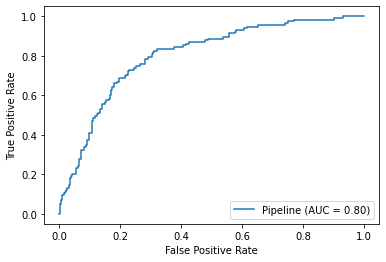

In [70]:
plot_roc_curve(logreg_corr, X_test, y_test)

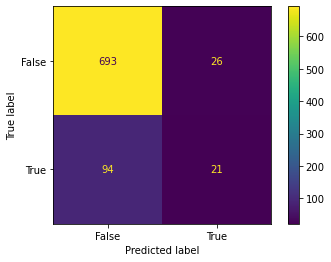

In [71]:
plot_confusion_matrix(logreg_corr, X_test, y_test)

In [73]:
print(classification_report(y_test, logreg_corr.predict(X_test)))

              precision    recall  f1-score   support

       False       0.88      0.96      0.92       719
        True       0.45      0.18      0.26       115

    accuracy                           0.86       834
   macro avg       0.66      0.57      0.59       834
weighted avg       0.82      0.86      0.83       834



Seems like it had the opposite effect, I will try doing a polynomial features on the columns to see if that increases the recall at all.

## Polynomial Feature Model

In [76]:
subpipe_numeric_pf = Pipeline(steps =[
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures())
])


In [77]:
CT_pf = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_numeric_pf,numeric_cols),
    ('subpipe_cat', subpipe_cat, cat_cols)
])

In [78]:
logreg_pf = Pipeline(steps = [
    ('ct',CT_pf),
    ('logreg', LogisticRegression())
])

In [91]:
logreg_pf.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('pf',
                                                                   PolynomialFeatures())]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve mi

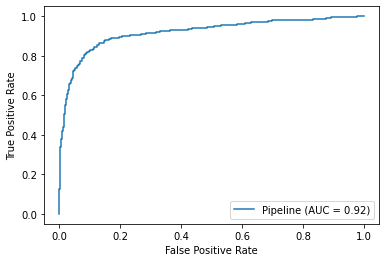

In [92]:
plot_roc_curve(logreg_pf, X_train, y_train)

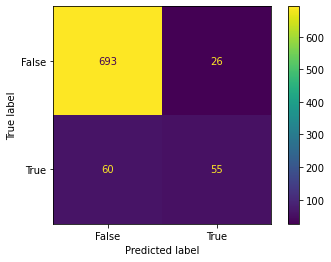

In [93]:
plot_confusion_matrix(logreg_pf, X_test, y_test)

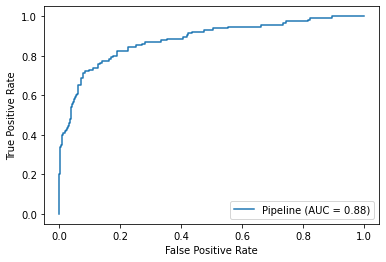

In [94]:
plot_roc_curve(logreg_pf, X_test, y_test)

In [95]:
print(classification_report(y_test, logreg_pf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.92      0.96      0.94       719
        True       0.68      0.48      0.56       115

    accuracy                           0.90       834
   macro avg       0.80      0.72      0.75       834
weighted avg       0.89      0.90      0.89       834



Wow, these polynomial features have more than doubled the recall and also increased the accuracy, I'll try increasing the degrees one more time

## Polynomial Feature Degree 3 Model

In [86]:
subpipe_numeric_pf2 = Pipeline(steps =[
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(degree = 3))
])


In [87]:
CT_pf2 = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_numeric_pf2,numeric_cols),
    ('subpipe_cat', subpipe_cat, cat_cols)
])

In [88]:
logreg_pf2 = Pipeline([
    ('ct',CT_pf2),
    ('logreg', LogisticRegression())
])

In [96]:
logreg_pf2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('pf',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'tota

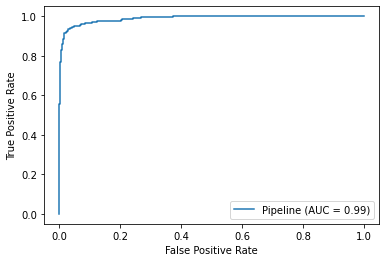

In [97]:
plot_roc_curve(logreg_pf2, X_train, y_train)

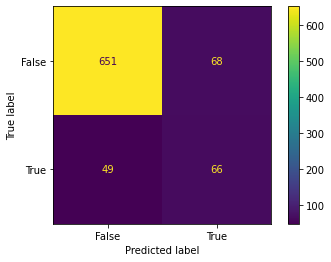

In [98]:
plot_confusion_matrix(logreg_pf2, X_test, y_test)

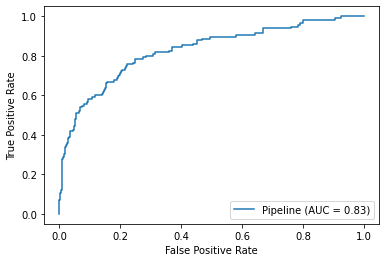

In [99]:
plot_roc_curve(logreg_pf2, X_test, y_test)

In [100]:
print(classification_report(y_test, logreg_pf2.predict(X_test)))

              precision    recall  f1-score   support

       False       0.93      0.91      0.92       719
        True       0.49      0.57      0.53       115

    accuracy                           0.86       834
   macro avg       0.71      0.74      0.72       834
weighted avg       0.87      0.86      0.86       834



A degree of 3 seems to be a good point as the accuracy is starting to decrease and recall didn't increase as much between these two values, for fun let's go one step deeper tho

## Polynomial Features Degree 4 Model

In [101]:
subpipe_numeric_pf3 = Pipeline(steps =[
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(degree = 4))
])


In [102]:
CT_pf3 = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_numeric_pf3,numeric_cols),
    ('subpipe_cat', subpipe_cat, cat_cols)
])

In [103]:
logreg_pf3 = Pipeline([
    ('ct',CT_pf3),
    ('logreg', LogisticRegression(C = .0001))
])

In [104]:
logreg_pf3.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('pf',
                                                                   PolynomialFeatures(degree=4))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'tota

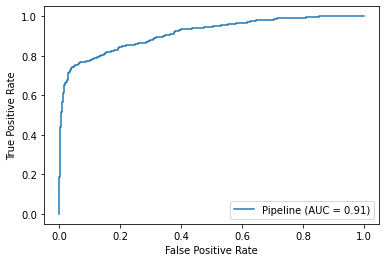

In [105]:
plot_roc_curve(logreg_pf3, X_train, y_train)

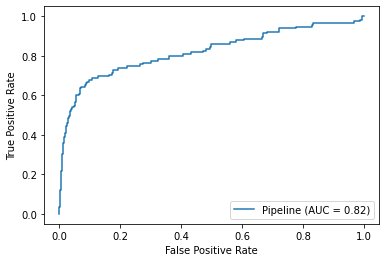

In [106]:
plot_roc_curve(logreg_pf3, X_test, y_test)

In [107]:
print(classification_report(y_test, logreg_pf3.predict(X_test)))

              precision    recall  f1-score   support

       False       0.90      0.99      0.94       719
        True       0.82      0.32      0.46       115

    accuracy                           0.90       834
   macro avg       0.86      0.66      0.70       834
weighted avg       0.89      0.90      0.88       834



Seems like we should stick with a maximum degree of 3

# Grid Search on Polynomial Features Degree of 3 Model

In [111]:
grid = {
    'logreg__penalty' : ['none','l1','l2','elasticnet'],
    'logreg__max_iter' : [10,100,1000],
    'logreg__C' : [0.000001, 0.00001, 0.0001, 0.001],
    'logreg__tol' : [.0001, .001, .01, .1],
    'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [112]:
gs = GridSearchCV(logreg_pf2, param_grid = grid, verbose =1, cv = 3)

In [113]:
# Commenting out grid serach to save time hopefully 

#gs.fit(X_train,y_train)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3456 out of 3456 | elapsed:  9.7min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler()),
                                                                                         ('pf',
                                                                                          PolynomialFeatures(degree=3))]),
                                                                         ['account '
                                                                          'length',
                                          

In [115]:
#print(gs.best_params_)
#print(gs.best_score_)

{'logreg__C': 1e-05, 'logreg__max_iter': 100, 'logreg__penalty': 'none', 'logreg__solver': 'sag', 'logreg__tol': 0.001}
0.9143657462985194


## Best Model with grid search parameters #1

In [116]:
CT_cols = ColumnTransformer(transformers=[
    ('num_cols',subpipe_numeric_pf2, numeric_cols),
    ('ohe', OneHotEncoder(), cat_cols)
])

In [117]:
best_model = Pipeline([
    ('ct', CT_cols),
    ('logreg', LogisticRegression(C = 1e-05, max_iter= 100, penalty= 'none', solver= 'sag', tol= 0.0001))
])

In [118]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('pf',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total e

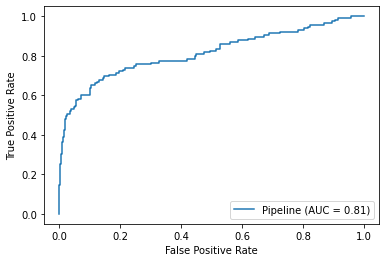

In [119]:
plot_roc_curve(best_model, X_test, y_test)

In [120]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.92      0.97      0.95       719
        True       0.72      0.50      0.59       115

    accuracy                           0.90       834
   macro avg       0.82      0.74      0.77       834
weighted avg       0.90      0.90      0.90       834



## Best Model with grid search parameters #2

In [121]:
logreg_pf2_gs = Pipeline([
    ('ct',CT_pf2),
    ('logreg', LogisticRegression(C = 1e-05, max_iter= 100, penalty= 'none', solver= 'sag', tol= 0.0001))
])

In [122]:
logreg_pf2_gs.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler()),
                                                                  ('pf',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['account length',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'tota

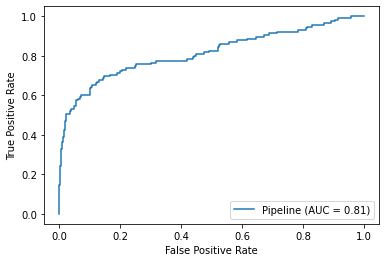

In [123]:
plot_roc_curve(logreg_pf2_gs, X_test, y_test)

In [124]:
print(classification_report(y_test, logreg_pf2_gs.predict(X_test)))

              precision    recall  f1-score   support

       False       0.92      0.97      0.95       719
        True       0.74      0.50      0.60       115

    accuracy                           0.91       834
   macro avg       0.83      0.74      0.77       834
weighted avg       0.90      0.91      0.90       834



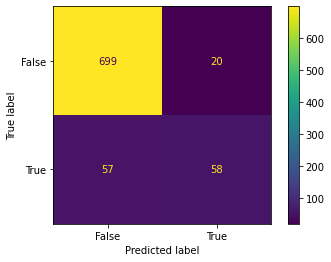

In [125]:
plot_confusion_matrix(logreg_pf2_gs, X_test, y_test)

# Interpreting coefficients

In [126]:
categorical_feature_names = CT_pf.named_transformers_['subpipe_cat'].named_steps['ohe'].get_feature_names(input_features = cat_cols)
poly_feature_names = CT_pf.named_transformers_['subpipe_num'].named_steps['pf'].get_feature_names(input_features = numeric_cols)
allcols = poly_feature_names + list(categorical_feature_names)

# Getting the feature names to relate to the coefficients

In [127]:
# Making a  model to pull out the coefficients for the model

coefs = LogisticRegression(C = 1e-05, max_iter= 100, penalty= 'none', solver= 'sag', tol= 0.0001)

In [129]:
# Coefficients labeled and converted to % change on churn

pflist = list(zip(allcols, (np.exp(logreg_pf.named_steps['logreg'].coef_[0]) - 1)  *100))
sorted(pflist,key = lambda x:x[1])

[('international plan_no', -74.18933193439783),
 ('state_HI', -73.14575743625949),
 ('state_VT', -62.260026072332174),
 ('state_AK', -50.03269737335461),
 ('state_AZ', -47.83689593781262),
 ('voice mail plan_yes', -45.64119703778737),
 ('state_NM', -43.46671922599612),
 ('state_UT', -39.97774883085352),
 ('state_AL', -39.60448168674764),
 ('state_NC', -37.16403146108757),
 ('state_IL', -36.392161741164784),
 ('state_VA', -36.162591354776765),
 ('state_FL', -36.058990216148565),
 ('state_CO', -35.929461361583094),
 ('total intl calls', -34.4959145453973),
 ('state_DC', -33.03044668201473),
 ('state_WV', -32.75866071659983),
 ('state_WI', -31.47805849270654),
 ('state_ND', -30.42181066438391),
 ('total day minutes customer service calls', -30.108474749752567),
 ('total day charge customer service calls', -29.261344880779085),
 ('state_WY', -28.062670043073933),
 ('state_DE', -26.885463461550387),
 ('state_RI', -23.566426215000757),
 ('number vmail messages total day minutes', -21.6786396

Seems like the international plan and voicemail plan have the largest change between being, the states seem to have a big impact but I don't know how to interpret that with the data I have currently.  The amount of customer service calls also seems to add quite a bit of a chance for subscribers to churn.